In [1]:
import torch.nn as nn
import torch
import torchvision.transforms as transforms
from torchsummary import summary
import torchvision
import time
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import os
from google.colab import files
from google.colab import drive
from PIL import Image



Mounted at /content/drive
Done


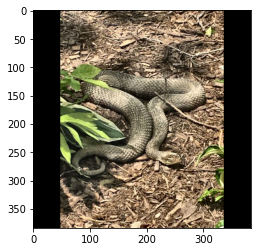

In [2]:
drive.mount('/content/drive')
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/5-class.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

image = plt.imread('/content/5-class/preprocessed-cleaned-set/train/class-1/00056e9548477cda7a885bb423cb668c.jpg')
imageShow = plt.imshow(image)

In [3]:
resnet18Model=models.resnet18(pretrained=False)
num_filters = resnet18Model.fc.in_features
num_classes = 5 
resnet18Model.fc = nn.Linear(num_filters,num_classes)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
resnet18Model.load_state_dict(torch.load('/content/5-class-100-epochos-output.pt'))

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [4]:
# https://ravivaishnav20.medium.com/visualizing-feature-maps-using-pytorch-12a48cd1e573
# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []
# get all the model children as list
model_children = list(resnet18Model.children())
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter+=1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter+=1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolution layers: {counter}")
print("conv_layers")

Total convolution layers: 17
conv_layers


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = resnet18Model.to(device)

Image shape before: torch.Size([3, 224, 224])
Image shape after: torch.Size([1, 3, 224, 224])


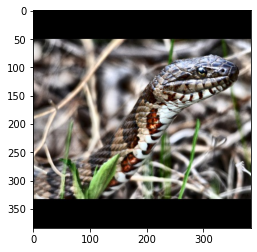

In [10]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=0., std=1.)
])

image = Image.open(str('/content/5-class/preprocessed-cleaned-set/train/class-1/0a006d8501f3ec1dd144b9c68dc9f542.jpg'))
plt.imshow(image)

image = transform(image)
print(f"Image shape before: {image.shape}")
image = image.unsqueeze(0)
print(f"Image shape after: {image.shape}")
image = image.to(device)

In [ ]:
outputs = []
names = []
for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))
#print feature_maps
for feature_map in outputs:
    print(feature_map.shape)

In [ ]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

In [ ]:
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=30)
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

In [ ]:
import random
seed = 10
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

In [5]:

#import this file to train models and pass the  name of the datset
# extract zip files
# load the images and labels based on the dataset requested
# do the pre-processing , batch normalization , flip etc

# Transofrmations for preprocessedSnakeImages dataset
# Reference from https://www.youtube.com/watch?v=z3kB3ISIPAg&list=PL3Dh_99BJkCEhE7Ri8W6aijiEqm3ZoGRq&index=4
training_path = '/content/5-class/preprocessed-cleaned-set/train/'
test_path = '/content/5-class/preprocessed-cleaned-set/test'
val_path = '/content/5-class/preprocessed-cleaned-set/val'
def transformDS1( batchSize, inputSize):

    training_transforms = transforms.Compose([transforms.Resize((inputSize,inputSize)),transforms.ToTensor()])
    train_dataset = torchvision.datasets.ImageFolder(root=training_path,transform = training_transforms)
    train_Loader = torch.utils.data.DataLoader(dataset = train_dataset,batch_size=batchSize,shuffle=False)
    mean, std = get_mean_std(train_Loader)
    train_transforms = transforms.Compose([
        transforms.Resize((inputSize,inputSize)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))
    ])

    test_transforms = transforms.Compose([
        transforms.Resize((inputSize,inputSize)),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))
    ])

    val_transforms = transforms.Compose([
        transforms.Resize((inputSize,inputSize)),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))
    ])
    
    train_dataset = torchvision.datasets.ImageFolder(root=training_path,transform=train_transforms)
    test_dataset = torchvision.datasets.ImageFolder(root=test_path,transform=test_transforms)
    val_dataset = torchvision.datasets.ImageFolder(root=val_path,transform=val_transforms)

    data_loader_train = torch.utils.data.DataLoader(train_dataset, batch_size=batchSize,
    shuffle=True,drop_last=False,num_workers=0)
    data_loader_test = torch.utils.data.DataLoader(test_dataset, batch_size=batchSize,
    shuffle=True,drop_last=False,num_workers=0)
    data_loader_val = torch.utils.data.DataLoader(val_dataset, batch_size=batchSize,
    shuffle=True,drop_last=False,num_workers=0)

    return data_loader_train,data_loader_test,data_loader_val

def get_mean_std(loader):
    mean = 0.
    std = 0.
    total_images_count = 0
    for images,_ in loader:
        images_count_in_batch = images.size(0)
        images =images.view(images_count_in_batch,images.size(1),-1)
        mean+=images.mean(2).sum(0)
        std+=images.std(2).sum(0)
        total_images_count+=images_count_in_batch
    mean /= total_images_count
    std /= total_images_count
    return mean,std

In [6]:
train_loader,test_loader,val_loader = transformDS1(32,224)

In [ ]:
#Due to computational complexity, we just select a part of the data.
X=test_loader[0]
Y=test_loader[1]
X=X.reshape(X.shape[0],X.shape[1]*X.shape[2])


print(X.shape)
print(Y.shape)

In [ ]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, init='random').fit_transform(X)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import scatter
#Make a scatter plot with X_embedded

#TODO: Using Plt.scatter, visualize the transformed data marked with their corresponding label in 2D embedding.

classes=list(set(Y))
plt.figure()

for cl in classes:
    indices = np.where(Y==cl)[0]
    plt.title('T-SNE Visualization')
    plt.scatter(X_embedded[indices,0], X_embedded[indices, 1], label=cl)
    plt.ylabel('Dim_2')
    plt.xlabel('Dim_1')

plt.legend()

In [7]:
def get_representations(model, iterator):
    model.eval()
    outputs = []
    intermediates = []
    labels = []
    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y_pred = model(x)
            outputs.append(y_pred.cpu())
            labels.append(y)
        
    outputs = torch.cat(outputs, dim = 0)
    labels = torch.cat(labels, dim = 0)
    return outputs, labels


In [11]:
outputs, labels = get_representations(resnet18Model, train_loader)

In [12]:
from sklearn import manifold

def get_tsne(data, n_components = 2, n_images = None):
    if n_images is not None:
        data = data[:n_images]
    tsne = manifold.TSNE(n_components = n_components, random_state = 0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

In [13]:
def plot_representations(data, labels, n_images = None):
            
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
                
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c = labels)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


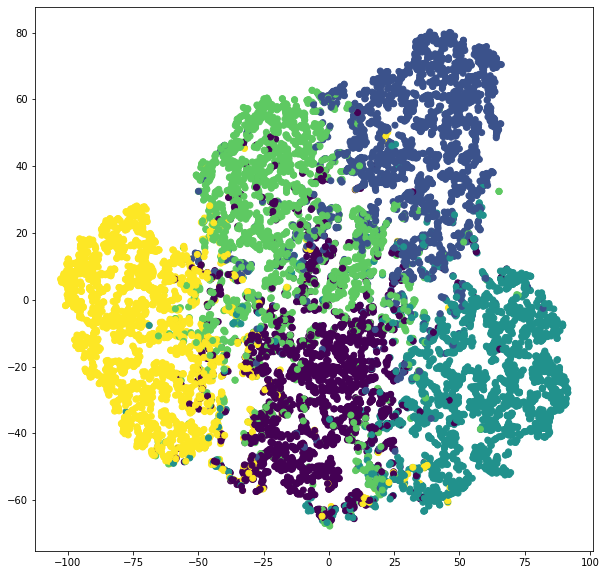

In [14]:
output_tsne_data = get_tsne(outputs)
plot_representations(output_tsne_data, labels)

In [15]:
output_tsne_data = get_tsne(outputs,n_components=3)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [16]:
def plot_representations_3d(data, labels, n_images = None):
            
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
    # fig, ax = plt.subplots(figsize=(10,10))
    fig = plt.figure(figsize = (16, 16))
    ax = fig.add_subplot(111,projection = '3d')
    scatter = ax.scatter(data[:, 0], data[:, 1],data[:, 2], c = labels)

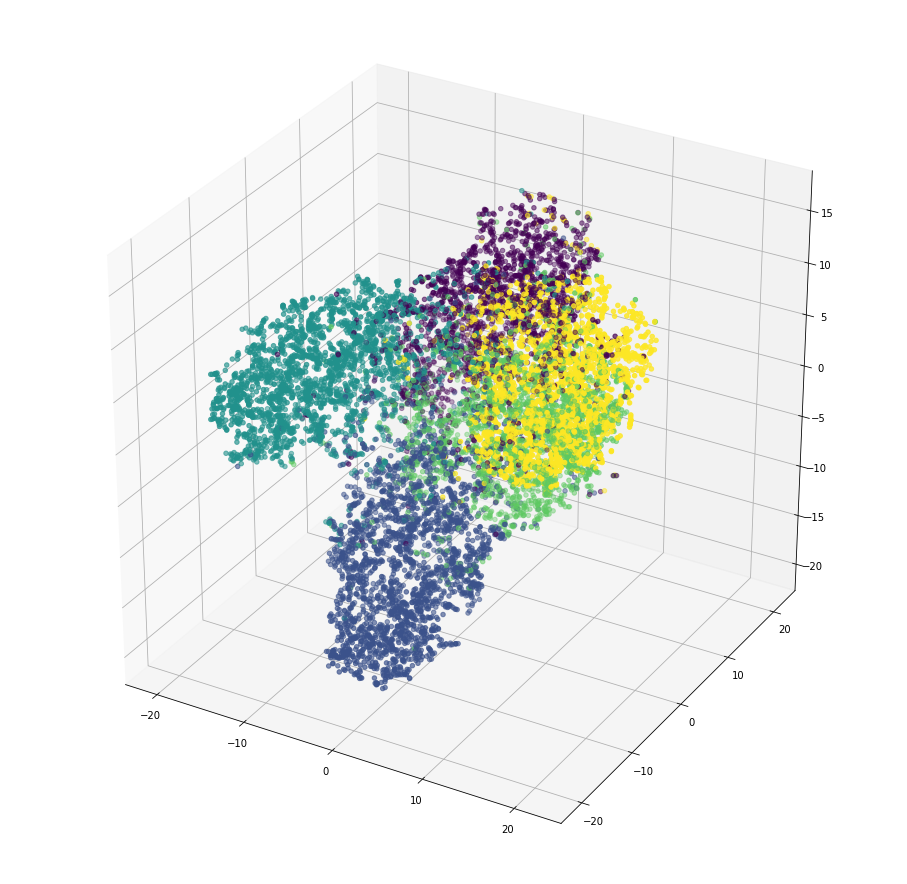

In [17]:
plot_representations_3d(output_tsne_data, labels)

In [18]:
from sklearn.decomposition import PCA

def get_pca(data, n_components = 2, n_images = None):
    if n_images is not None:
        data = data[:n_images]
    pca = PCA(n_components = n_components, random_state = 0)
    pca_data = pca.fit_transform(data)
    return pca_data

In [19]:
output_tsne_data = get_pca(outputs,n_components=3)


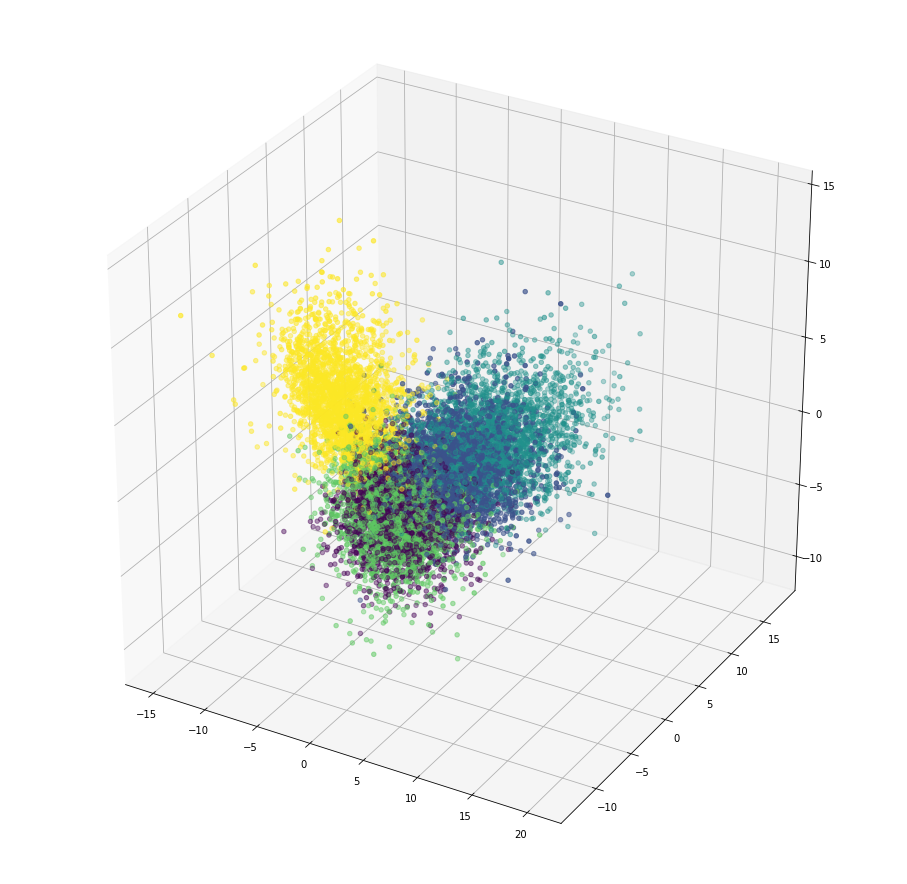

In [20]:
plot_representations_3d(output_tsne_data, labels)